In [ ]:
import pandas as pd 
# 读取数据
df = pd.read_csv('train.csv')
df.columns
# totalAcc postCode initialListStatus policyCode n0 n4 n6 n8 n13 regionCode
# n11 n12 regionCode

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [40]:
df['policyCode'].unique()

array([1.])

isDefault    1.000000
n14          0.085715
n3           0.070352
n2           0.070352
n9           0.068978
n1           0.040659
n7           0.032007
n10          0.025583
n4           0.013156
n0           0.010953
n13          0.010101
n6           0.005350
n12          0.003287
n11         -0.000293
n8          -0.005951
n5          -0.018661
Name: isDefault, dtype: float64


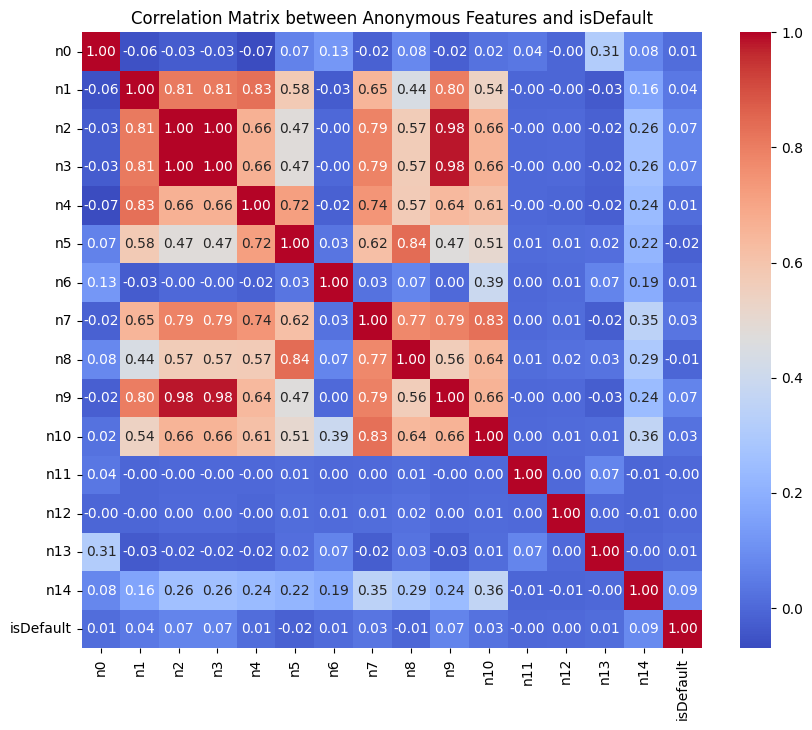

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 选择匿名列 + 目标列
anon_cols = [f"n{i}" for i in range(15)]
cols_to_check = anon_cols + ['isDefault']
df_corr = df[cols_to_check].corr()

# 显示 isDefault 的相关性部分
print(df_corr['isDefault'].sort_values(ascending=False))

# 可视化热力图
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Anonymous Features and isDefault")
plt.show()


In [44]:
from sklearn.feature_selection import mutual_info_classif

X = df[anon_cols].fillna(0)
y = df['isDefault']
mi_scores = mutual_info_classif(X, y, discrete_features=False)

# 打印每个匿名特征与 isDefault 的互信息
for name, score in zip(anon_cols, mi_scores):
    print(f"{name}: {score:.4f}")


n0: 0.0021
n1: 0.0165
n2: 0.0139
n3: 0.0134
n4: 0.0113
n5: 0.0073
n6: 0.0045
n7: 0.0092
n8: 0.0039
n9: 0.0138
n10: 0.0075
n11: 0.0000
n12: 0.0008
n13: 0.0017
n14: 0.0221


In [49]:
# 计算违约率（isDefault == 1 的比例）
rate = df['isDefault'].mean()
print(f"违约率: {rate:.2%}")


违约率: 19.95%


In [48]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 读取数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('testA.csv')

# 预处理函数同你之前定义的
def preprocess_data(df):
    df = df.drop(columns=['postCode', 'n11', 'n12'])

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

    cat_cols = df.select_dtypes(include=['object']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    for column in cat_cols:
        df[column] = LabelEncoder().fit_transform(df[column])

    return df

# 数据预处理
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# 特征和标签划分
X = train_data.drop(columns=['id', 'isDefault'])
y = train_data['isDefault']
X_test = test_data.drop(columns=['id'])

# CatBoost 分类模型超参数
params = {
    'iterations': 5000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 200
}

# 分类变量（注意：LabelEncoder 后不再需要 cat_features）
cat_features = []

# K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
test_preds = np.zeros(len(X_test))

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True)

    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)

    print(f"Fold {fold+1} AUC: {auc:.4f}")

    # 累加测试集预测结果（用于平均）
    test_preds += model.predict_proba(X_test)[:, 1] / kf.n_splits

print("\nAverage AUC across folds:", np.mean(auc_scores))

# 保存预测结果
submission = pd.DataFrame({'id': test_data['id'], 'isDefault': test_preds})
submission.to_csv('submission_kfold.csv', index=False)
print("Cross-validated submission file created.")



Fold 1:
Fold 1 AUC: 0.7363

Fold 2:
Fold 2 AUC: 0.7377

Fold 3:
Fold 3 AUC: 0.7343

Fold 4:
Fold 4 AUC: 0.7340

Fold 5:
Fold 5 AUC: 0.7394

Average AUC across folds: 0.7363359896913726
Cross-validated submission file created.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# import xgboost as xgb
# from lightgbm import LGBMClassifier

# 读取数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('testA.csv')

# # 数据理解和统计描述
# print(train_data.head())
# print(train_data.describe())
# print(train_data.info())

# # 数据可视化
# # 目标变量的分布
# plt.figure(figsize=(6,4))
# sns.countplot(x='isDefault', data=train_data)
# plt.title('Distribution of Target Variable')
# plt.show()

# # 各个特征与目标变量的关系
# plt.figure(figsize=(16,12))
# sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# 数据预处理
def preprocess_data(df):
    # 脱敏处理
    df = df.drop(columns=['postCode', 'policyCode', 'regionCode'])

    # 处理数值变量的缺失值
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # 处理分类变量的缺失值
    # cat_cols = df.select_dtypes(include=['object']).columns
    # cat_imputer = SimpleImputer(strategy='most_frequent')
    # df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # # 处理分类变量编码
    # for column in cat_cols:
    #     df[column] = LabelEncoder().fit_transform(df[column])

    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# 特征选择和数据标准化
X = train_data.drop(columns=['id', 'isDefault'])
y = train_data['isDefault']
X_test = test_data.drop(columns=['id'])

# 特征选择：选择与目标变量相关性较高的特征
# corr_matrix = train_data.corr()
# high_corr_features = corr_matrix.index[abs(corr_matrix["isDefault"]) > 0.05]
# X = train_data[high_corr_features].drop(columns=['isDefault'])
# X_test = test_data[high_corr_features.drop('isDefault')]

# 保存特征名称
# feature_names = X.columns

# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X_test = scaler.transform(X_test)

# 分割训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 使用较小的数据子集来调试和验证各种模型
# X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)



# 假设已有数据：X_train, y_train, X_val, y_val
# 如果你有完整数据，可以如下划分（含验证集）：
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 指定类别型特征的列名或索引
# 示例：cat_cols = ['gender', 'education', 'marital_status']
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' or 'category' in str(X_train[col].dtype)]

# 创建模型
cat_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    cat_features=cat_cols,
    early_stopping_rounds=5000,
    verbose=100
)

# 拟合模型
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    # plot=True 
)

# 预测验证集概率（违约概率）
y_val_pred_cat = cat_model.predict_proba(X_val)[:, 1]

# 计算 AUC
auc_score_cat = roc_auc_score(y_val, y_val_pred_cat)
print(f'CatBoost Validation AUC Score: {auc_score_cat:.4f}')

best_model = cat_model
best_auc = auc_score_cat

print(f'Best Model is {best_model}')
print(f'Best Model AUC: {best_auc}')

# 使用全量数据训练最佳模型
best_model.fit(X_train, y_train)

# 在测试集上进行预测
test_pred = best_model.predict_proba(X_test)[:, 1]

# 结果提交
submission = pd.DataFrame({'id': test_data['id'], 'isDefault': test_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

